In [8]:
import argparse
import gym
from vans_gym.envs import VansEnvsSeq
from vans_gym.solvers import CirqSolverR, Checker
from vans_gym.models import DuelDQN
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow as tf

In [49]:
solver = CirqSolverR(n_qubits = 2, observable_name="Ising_",qlr=0.05,qepochs=100)
checker = Checker(solver)

env = VansEnvsSeq(solver,checker=checker, depth_circuit=3)


model = DuelDQN(env, name="WorkingOut",
               priority_scale=0.0, learning_rate=0.00001, tau=0.05)
model.replay_buffer.load("DuelDQN/run_9/data_collected/")

In [50]:
qold = model.prim_qnet.predict(tf.stack(np.array([[-1.,-1.,-1.]]).astype(np.float32)))
qold

array([[-0.01276574,  0.21107237,  0.05765701,  0.05197726, -0.04438023,
         0.11725076]], dtype=float32)

In [65]:
def step(model):

    batch_size=128
    (states, actions, rewards, nstates, dones), importance, indices = model.replay_buffer.get_minibatch(batch_size=batch_size, priority_scale=model.priority_scale)

    arg_q_max = model.prim_qnet.predict(tf.stack(states)).argmax(axis=1)
    future_q_vals = model.target_qnet.predict(tf.stack(nstates))
    nextq = future_q_vals[range(batch_size), arg_q_max]
    target_q = rewards + (1-dones)*nextq

    with tf.GradientTape() as tape:
        tape.watch(model.prim_qnet.trainable_variables)
        qvalues = model.prim_qnet(tf.stack(states))
        Q = tf.reduce_sum(tf.multiply(qvalues, tf.keras.utils.to_categorical(actions, model.n_actions)), axis=1)
        error = target_q - Q  # this is for importance sample
        loss = tf.reduce_mean(tf.keras.losses.MSE(target_q, Q))
    grads = tape.gradient(loss, model.prim_qnet.trainable_variables)
    model.prim_qnet.optimizer.apply_gradients(zip(grads, model.prim_qnet.trainable_variables))
    model.update_target_parameters()

    return loss.numpy()

In [52]:
l=[]
for j in tqdm(range(10**3)):
    l.append(step(model))

100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


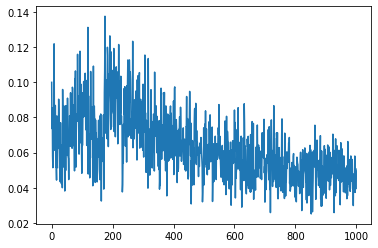

In [53]:
plt.plot(l)

In [57]:
state = model.env.reset()
done = False
while not done:
    action = model.give_action(state, ep=0)
    next_state, reward, done, info = model.env.step(action, evaluating=False)
    state = next_state


In [58]:
solver.run_circuit(state)

array(0.9999894, dtype=float32)

In [59]:
np.argmax(model.prim_qnet.predict(tf.stack(np.array([[-1.,-1.,-1.]]).astype(np.float32))))

5

In [60]:
model.prim_qnet.predict(tf.stack(np.array([[-1.,-1.,-1.]]).astype(np.float32)))

array([[-0.00524273,  0.02820227, -0.01312972, -0.00344125, -0.0773262 ,
         0.02826311]], dtype=float32)

In [62]:
model.prim_qnet.predict(tf.stack(np.array([[1.,-1.,-1.]]).astype(np.float32)))

array([[ 0.00542188, -0.03441755,  0.03545082,  0.05008619, -0.05239047,
        -0.04604851]], dtype=float32)

In [63]:
state = np.array([1.,-1.,-1.])
done = False
while not done:
    action = model.give_action(state, ep=0)
    next_state, reward, done, info = model.env.step(action, evaluating=False)
    state = next_state

In [64]:
reward

array(0.9999883, dtype=float32)

In [39]:
np.argmax(model.prim_qnet.predict(tf.stack(np.array([[4.,2.,-1.]]).astype(np.float32))))

4

In [40]:
np.argmax(model.prim_qnet.predict(tf.stack(np.array([[1.,-1.,-1.]]).astype(np.float32))))

5

In [41]:
np.argmax(model.prim_qnet.predict(tf.stack(np.array([[-1.,-1.,-1.]]).astype(np.float32))))

5

In [46]:
np.argmax(model.prim_qnet.predict(tf.stack(np.array([[5.,5.,3.]]).astype(np.float32))))

3